In [1]:
import numpy as np
from torch import nn
import torch
from tqdm import tqdm
from utils import *
import random
import os
import logging
import pickle
from copy import deepcopy

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, ConcatDataset, Dataset
import torchvision
import torchvision.transforms as transforms
from spiking_layer_ours import *  # Import custom spiking layer module
from Models import modelpool  # Import function to fetch models
from Preprocess import datapool, get_dataloader_from_dataset, load_dataset, split_dataset  # Import data preprocessing module
from torchvision.models.feature_extraction import create_feature_extractor
from torch.utils.data import Subset
import argparse
from funcs import *  # Import additional custom functions
import time
from utils import *  # Import utility functions
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve
warnings.filterwarnings("ignore")

In [2]:
MODEL = "resnet18"
DATASET = "cifar100"
CHECKPOINT = "saved_models"
REFERENCE_MODELS = 4
MODEL_IDX = 0
BATCH_SIZE = 64

GlobalLogger.initialize("./test.log")
logger = GlobalLogger.get_logger(__name__)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
primary_model_path = os.path.join(CHECKPOINT, DATASET, MODEL, f"ref_models_{REFERENCE_MODELS}")
dataset = load_dataset(DATASET, logger)
try:
    data_split_file = os.path.join(primary_model_path, "data_splits.pkl")
    with open(data_split_file, 'rb') as file:
        data_split_info = pickle.load(file)
    print("Data split information successfully loaded:")
except FileNotFoundError:
    print(f"Error: The file '{data_split_file}' does not exist")
train_idxs = data_split_info[MODEL_IDX]["train"]
test_idxs = data_split_info[MODEL_IDX]["test"]
print(f"Testing Model: Test size {len(test_idxs)}")
print("Creating dataloader...")
test_loader = get_dataloader_from_dataset(DATASET, Subset(dataset, test_idxs), batch_size=BATCH_SIZE, train=False)
train_loader = get_dataloader_from_dataset(DATASET, Subset(dataset, train_idxs), batch_size=BATCH_SIZE, train=True)
full_loader = get_dataloader_from_dataset(DATASET, Subset(dataset, np.concatenate((train_idxs, test_idxs), axis=0)), batch_size=BATCH_SIZE, train=False)

2025-01-29 21:50:30,463 - __main__ - INFO - Load data from datasets/cifar100.pkl
2025-01-29 21:50:30,468 - __main__ - INFO - The whole dataset size: 60000


Data split information successfully loaded:
Testing Model: Test size 30000
Creating dataloader...


### Compare results and ROC curve plotting 

In [4]:
def compute_attack_results(mia_scores, target_memberships):
    """
    Compute attack results (TPR-FPR curve, AUC, etc.) based on MIA scores and membership of samples.

    Args:
        mia_scores (np.array): MIA score computed by the attack.
        target_memberships (np.array): Membership of samples in the training set of target model.

    Returns:
        dict: Dictionary of results, including fpr and tpr list, AUC, TPR at 1%, 0.1% and 0% FPR.
    """
    fpr_list, tpr_list, thresholds = roc_curve(target_memberships.ravel(), mia_scores.ravel())
    roc_auc = auc(fpr_list, tpr_list)
    
    one_fpr = tpr_list[np.where(fpr_list <= 0.01)[0][-1]]
    one_tenth_fpr = tpr_list[np.where(fpr_list <= 0.001)[0][-1]]
    
    zero_fpr_indices = np.where(fpr_list == 0.0)[0]
    zero_fpr = tpr_list[zero_fpr_indices[-1]] if zero_fpr_indices.size > 0 else 0.0

    return {
        "fpr": fpr_list,
        "tpr": tpr_list,
        "auc": roc_auc,
        "one_fpr": one_fpr,
        "one_tenth_fpr": one_tenth_fpr,
        "zero_fpr": zero_fpr,
        "thresholds": thresholds
    }


def visualization(results):
    """
    visualize the attack results (ROC curve)
    """
    plt.figure(figsize=(8, 6))
    plt.plot(
        results["fpr"],
        results["tpr"],
        color="darkorange",
        lw=2,
        label=f"ROC curve (AUC = {results['auc']:.2f})",
    )
    plt.plot([0, 1], [0, 1], color="navy", linestyle="--", lw=2, label="Random Guess")
    # Add grid, labels, and legend
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title("TPR-FPR (ROC) Curve")
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()

# Model Loading

### load the target model of ANN

In [5]:
def eval_ann(test_dataloader, model, loss_fn, device, rank=0):
    logger.info("Starting evaluation...")
    epoch_loss = 0
    tot = torch.tensor(0.).cuda(device)
    model.eval()
    model.cuda(device)
    length = 0
    with torch.no_grad():
        for img, label in test_dataloader:
            img = img.cuda(device)
            label = label.cuda(device).long()
            out = model(img)
            loss = loss_fn(out, label)
            epoch_loss += loss.item()
            length += len(label)
            tot += (label == out.max(1)[1]).sum().data    
            accuracy = tot / length
    avg_loss = epoch_loss / length
    logger.info(f"Evaluation completed. Accuracy: {accuracy:.4f}, Loss: {avg_loss:.4f}")
    return accuracy, avg_loss

### Loading the target model ann and calculate the generlization gap = train_ac - tmp_acc

In [6]:
i=1
test_idxs = data_split_info[i]["test"]
test_loader = get_dataloader_from_dataset(DATASET, Subset(dataset, test_idxs), batch_size=BATCH_SIZE, train=False)
train_idxs = data_split_info[i]["train"]
train_loader = get_dataloader_from_dataset(DATASET, Subset(dataset, train_idxs), batch_size=BATCH_SIZE, train=False)


MODEL = "resnet18"
target_model_ann = modelpool(MODEL, DATASET)
target_model_ann.to(device)
model_path = os.path.join(primary_model_path, f"model_{MODEL_IDX}", "ann")
target_model_ann.load_state_dict(torch.load(model_path + '.pth'))
criterion = nn.CrossEntropyLoss()
tmp_acc, val_loss = eval_ann(test_loader, target_model_ann, criterion, device)
print(f"Validation Accuracy: {tmp_acc} | Validation Loss: {val_loss}")
train_ac, val_loss = eval_ann(train_loader, target_model_ann, criterion, device)
print(f"train Accuracy: {train_ac} | Validation Loss: {val_loss}")
print(f"generlization gap : {(train_ac - tmp_acc)*100}%")

2025-01-29 21:51:45,009 - __main__ - INFO - Starting evaluation...
2025-01-29 21:53:17,466 - __main__ - INFO - Evaluation completed. Accuracy: 0.8324, Loss: 0.0101
2025-01-29 21:53:17,470 - __main__ - INFO - Starting evaluation...


Validation Accuracy: 0.8324333429336548 | Validation Loss: 0.01008195117712021


2025-01-29 21:54:48,951 - __main__ - INFO - Evaluation completed. Accuracy: 0.8347, Loss: 0.0100


train Accuracy: 0.8346999883651733 | Validation Loss: 0.009950861406326294
generlization gap : 0.22666454315185547%


In [8]:
reference_models_anns = []
for i in range(1,5):
    reference_models_ann = modelpool(MODEL, DATASET)
    reference_models_ann.to(device)
    model_path = os.path.join(primary_model_path, f"model_{i}", "ann")
    reference_models_ann.load_state_dict(torch.load(model_path + '.pth'))
    reference_models_anns.append(reference_models_ann)
    criterion = nn.CrossEntropyLoss()
    test_idxs = data_split_info[i]["test"]
    test_loader = get_dataloader_from_dataset(DATASET, Subset(dataset, test_idxs), batch_size=BATCH_SIZE, train=False)
    tmp_acc, val_loss = eval_ann(test_loader, reference_models_ann, criterion, device)
    print(f"Validation Accuracy: {tmp_acc} | Validation Loss: {val_loss}")

    train_idxs = data_split_info[i]["train"]
    train_loader = get_dataloader_from_dataset(DATASET, Subset(dataset, train_idxs), batch_size=BATCH_SIZE, train=False)
    train_ac, val_loss = eval_ann(train_loader, target_model_ann, criterion, device)
    print(f"train Accuracy: {train_ac} | Validation Loss: {val_loss}")
    print(f"generlization gap : {(train_ac - tmp_acc)*100}%")

2025-01-29 14:07:03,015 - __main__ - INFO - Starting evaluation...
2025-01-29 14:08:21,264 - __main__ - INFO - Evaluation completed. Accuracy: 0.6856, Loss: 0.0183
2025-01-29 14:08:21,264 - __main__ - INFO - Starting evaluation...


Validation Accuracy: 0.6856333613395691 | Validation Loss: 0.01831442252198855


2025-01-29 14:09:36,880 - __main__ - INFO - Evaluation completed. Accuracy: 0.8347, Loss: 0.0100


train Accuracy: 0.8346999883651733 | Validation Loss: 0.009950861406326294
generlization gap : 14.906662940979004%


2025-01-29 14:09:37,163 - __main__ - INFO - Starting evaluation...
2025-01-29 14:10:50,614 - __main__ - INFO - Evaluation completed. Accuracy: 0.6892, Loss: 0.0182
2025-01-29 14:10:50,621 - __main__ - INFO - Starting evaluation...


Validation Accuracy: 0.6892333626747131 | Validation Loss: 0.018219469316800435


2025-01-29 14:12:06,041 - __main__ - INFO - Evaluation completed. Accuracy: 0.8324, Loss: 0.0101


train Accuracy: 0.8324333429336548 | Validation Loss: 0.01008195117712021
generlization gap : 14.319997787475586%


2025-01-29 14:12:06,313 - __main__ - INFO - Starting evaluation...
2025-01-29 14:13:21,849 - __main__ - INFO - Evaluation completed. Accuracy: 0.6877, Loss: 0.0183
2025-01-29 14:13:21,851 - __main__ - INFO - Starting evaluation...


Validation Accuracy: 0.6877000331878662 | Validation Loss: 0.01829907915790876


2025-01-29 14:14:33,189 - __main__ - INFO - Evaluation completed. Accuracy: 0.8330, Loss: 0.0101


train Accuracy: 0.8330000042915344 | Validation Loss: 0.010087538230915865
generlization gap : 14.529996871948242%


2025-01-29 14:14:33,428 - __main__ - INFO - Starting evaluation...
2025-01-29 14:15:43,163 - __main__ - INFO - Evaluation completed. Accuracy: 0.6883, Loss: 0.0183
2025-01-29 14:15:43,165 - __main__ - INFO - Starting evaluation...


Validation Accuracy: 0.6883333325386047 | Validation Loss: 0.018343879957993824


2025-01-29 14:16:55,015 - __main__ - INFO - Evaluation completed. Accuracy: 0.8341, Loss: 0.0099


train Accuracy: 0.8341333270072937 | Validation Loss: 0.009944948221246402
generlization gap : 14.579999923706055%


### load the target model of SNN

In [10]:
def test_snn(model, test_loader, n_steps, criterion, device):
    logger.info("Testing SNN...")
    model.to(device)
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        loss = 0
        for images, labels in test_loader:
            images = add_dimension(images, n_steps)
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images, L=0, t=n_steps)
            outputs = torch.sum(outputs, 1)
            _, predicted = torch.max(outputs.data/n_steps, 1)
            loss += criterion(outputs/n_steps, labels).item()*images.shape[0]
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        test_loss = loss/total
        test_acc = 100 * correct / total
    logger.info(f"SNN Testing Complete. Loss: {test_loss:.4f}, Accuracy: {test_acc:.2f}%")
    return test_loss, test_acc

    

def isActivation(name):
    if 'relu' in name.lower():
        return True
    return False


def replace_activation_by_spike(model, thresholds, thresholds1, n_steps, counter=0):
    thresholds_new = deepcopy(thresholds)
    thresholds_new1 = deepcopy(thresholds1)

    for name, module in model._modules.items():
        if hasattr(module, "_modules"):
            model._modules[name], counter, thresholds_new = replace_activation_by_spike(module, thresholds_new, thresholds_new1, n_steps, counter)
        if isActivation(module.__class__.__name__.lower()):
            thresholds_new[counter, n_steps:] = thresholds_new1[counter, 1] / n_steps
            thresholds_new[counter, :n_steps] = thresholds_new1[counter, 0] / n_steps
            model._modules[name] = SPIKE_layer(thresholds_new[counter, n_steps:], thresholds_new[counter, 0:n_steps])
            counter += 1
    return model, counter, thresholds_new

def ann_to_snn(model, thresholds, thresholds1, n_steps):
    logger.info("Converting ANN to SNN...")
    model, counter, thresholds_new = replace_activation_by_spike(model, thresholds, thresholds1, n_steps)
    model = replace_maxpool2d_by_avgpool2d(model)
    model = replace_layer_by_tdlayer(model)
    logger.info("Conversion complete.")
    return model, thresholds_new

Loading the target model snn(T=1)

In [12]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_steps = 1
i = 0
target_model_snn = modelpool(MODEL, DATASET)
model_path = os.path.join(primary_model_path, f"model_{MODEL_IDX}", "ann_snn_T1")
savename = os.path.join(primary_model_path, f"model_{MODEL_IDX}", "ann")
num_relu = str(target_model_snn).count('ReLU')
thresholds = torch.zeros(num_relu, 2*n_steps)
thresholds1 = torch.Tensor(np.load('%s_threshold_all_noaug%d.npy' % (savename, 1)))
target_model_snn, threshold_new = ann_to_snn(target_model_snn, thresholds, thresholds1, n_steps)
target_model_snn.load_state_dict(torch.load(model_path + '.pth'))
criterion = nn.CrossEntropyLoss()
test_idxs = data_split_info[i]["test"]
test_loader = get_dataloader_from_dataset(DATASET, Subset(dataset, test_idxs), batch_size=BATCH_SIZE, train=False)
test_loss, test_acc = test_snn(target_model_snn, test_loader, n_steps, criterion, device)
print(f"Test Accuracy: {test_acc} | Test Loss: {test_loss}")


train_idxs = data_split_info[i]["train"]
train_loader = get_dataloader_from_dataset(DATASET, Subset(dataset, train_idxs), batch_size=BATCH_SIZE, train=False)
train_loss, train_acc = test_snn(target_model_snn, train_loader, n_steps, criterion, device)
print(f"Train Accuracy: {train_acc} | Train Loss: {train_loss}")

print(f"generlization gap : {(train_acc - test_acc)}%")

2025-01-29 14:17:51,938 - funcs - INFO - Converting ANN to SNN...
2025-01-29 14:17:51,964 - funcs - INFO - Conversion complete.
2025-01-29 14:17:52,191 - funcs - INFO - Testing SNN...
2025-01-29 14:19:11,007 - funcs - INFO - SNN Testing Complete. Loss: 1.4623, Accuracy: 59.59%
2025-01-29 14:19:11,011 - funcs - INFO - Testing SNN...


Test Accuracy: 59.593333333333334 | Test Loss: 1.4622739136377971


2025-01-29 14:20:28,284 - funcs - INFO - SNN Testing Complete. Loss: 0.8608, Accuracy: 75.38%


Train Accuracy: 75.37666666666667 | Train Loss: 0.8607675050417583
generlization gap : 15.783333333333331%


Loading the shodow models snn(T=1) 

In [13]:
reference_models_snn = []
for i in range(1,5):
    model_snn = modelpool(MODEL, DATASET)
    model_path = os.path.join(primary_model_path, f"model_{i}", "ann_snn_T1")
    savename = os.path.join(primary_model_path, f"model_{i}", "ann")
    num_relu = str(model_snn).count('ReLU')
    thresholds = torch.zeros(num_relu, 2*n_steps)
    thresholds1 = torch.Tensor(np.load('%s_threshold_all_noaug%d.npy' % (savename, 1)))
    model_snn, threshold_new = ann_to_snn(model_snn, thresholds, thresholds1, n_steps)
    model_snn.load_state_dict(torch.load(model_path + '.pth'))
    criterion = nn.CrossEntropyLoss()
    test_idxs = data_split_info[i]["test"]
    test_loader = get_dataloader_from_dataset(DATASET, Subset(dataset, test_idxs), batch_size=BATCH_SIZE, train=False)
    test_loss, test_acc = test_snn(model_snn, test_loader, n_steps, criterion, device)
    print(f"Test Accuracy: {test_acc} | Test Loss: {test_loss}")

    train_idxs = data_split_info[i]["train"]
    train_loader = get_dataloader_from_dataset(DATASET, Subset(dataset, train_idxs), batch_size=BATCH_SIZE, train=False)
    train_loss, train_acc = test_snn(model_snn, train_loader, n_steps, criterion, device)
    print(f"Train Accuracy: {train_acc} | Train Loss: {train_loss}")
    print(f"generlization gap : {(train_acc - test_acc)}%")
    
    reference_models_snn.append(model_snn)

2025-01-29 14:20:28,405 - funcs - INFO - Converting ANN to SNN...
2025-01-29 14:20:28,411 - funcs - INFO - Conversion complete.
2025-01-29 14:20:28,515 - funcs - INFO - Testing SNN...
2025-01-29 14:21:44,634 - funcs - INFO - SNN Testing Complete. Loss: 1.4800, Accuracy: 58.92%
2025-01-29 14:21:44,644 - funcs - INFO - Testing SNN...


Test Accuracy: 58.92 | Test Loss: 1.4800459496180216


2025-01-29 14:23:00,886 - funcs - INFO - SNN Testing Complete. Loss: 0.8380, Accuracy: 75.74%
2025-01-29 14:23:00,984 - funcs - INFO - Converting ANN to SNN...
2025-01-29 14:23:00,995 - funcs - INFO - Conversion complete.
2025-01-29 14:23:01,094 - funcs - INFO - Testing SNN...


Train Accuracy: 75.73666666666666 | Train Loss: 0.8380211773236592
generlization gap : 16.816666666666663%


2025-01-29 14:24:18,644 - funcs - INFO - SNN Testing Complete. Loss: 1.4747, Accuracy: 59.24%
2025-01-29 14:24:18,644 - funcs - INFO - Testing SNN...


Test Accuracy: 59.24333333333333 | Test Loss: 1.4746912109375


2025-01-29 14:25:35,872 - funcs - INFO - SNN Testing Complete. Loss: 0.8532, Accuracy: 75.35%
2025-01-29 14:25:35,956 - funcs - INFO - Converting ANN to SNN...
2025-01-29 14:25:35,963 - funcs - INFO - Conversion complete.


Train Accuracy: 75.35333333333334 | Train Loss: 0.8531732505480448
generlization gap : 16.110000000000007%


2025-01-29 14:25:36,079 - funcs - INFO - Testing SNN...
2025-01-29 14:26:52,460 - funcs - INFO - SNN Testing Complete. Loss: 1.4799, Accuracy: 59.38%
2025-01-29 14:26:52,461 - funcs - INFO - Testing SNN...


Test Accuracy: 59.376666666666665 | Test Loss: 1.4799201117833456


2025-01-29 14:28:10,455 - funcs - INFO - SNN Testing Complete. Loss: 0.8429, Accuracy: 75.83%
2025-01-29 14:28:10,534 - funcs - INFO - Converting ANN to SNN...
2025-01-29 14:28:10,544 - funcs - INFO - Conversion complete.
2025-01-29 14:28:10,650 - funcs - INFO - Testing SNN...


Train Accuracy: 75.83 | Train Loss: 0.8429406911532085
generlization gap : 16.453333333333333%


2025-01-29 14:29:27,545 - funcs - INFO - SNN Testing Complete. Loss: 1.4735, Accuracy: 59.15%
2025-01-29 14:29:27,546 - funcs - INFO - Testing SNN...


Test Accuracy: 59.15 | Test Loss: 1.473539444478353


2025-01-29 14:30:44,975 - funcs - INFO - SNN Testing Complete. Loss: 0.8483, Accuracy: 75.51%


Train Accuracy: 75.50666666666666 | Train Loss: 0.8483385525067647
generlization gap : 16.356666666666662%


## Attack Method

## Attack P

## Compute confidence without introducing noise

In [14]:
def compute_confidence_ann(model, data_loader, device):
    """
    Compute the confidence of each sample in the dataset.

    Args:
        model (torch.nn.Module): The trained model.
        dataset (torch.utils.data.Dataset): The dataset.
        device (torch.device): The computation device (e.g., 'cpu' or 'cuda').

    Returns:
        confidence_list (torch.Tensor): The confidence of each sample (softmax probability for the correct class).
    """


    # Set the model to evaluation mode
    model.eval()
    model.to(device)

    confidence_list = []

    # Disable gradient computation
    with torch.no_grad():
        for images, labels in data_loader:
            # Move data to the specified device
            #images = add_dimension(images, n_steps)
            images = images.to(device)
            labels = labels.to(device)

            # Compute logits
            logits = model(images)

            # Compute softmax probabilities
            softmax_values = F.softmax(logits, dim=1)

            # Extract probabilities for the correct class
            confidences = softmax_values[range(len(labels)), labels]

            # Collect the results
            confidence_list.append(confidences)

    # Concatenate results from all batches
    confidence_list = torch.cat(confidence_list, dim=0)

    #numpy
    confidence_list = confidence_list.cpu().numpy()

    return confidence_list


def compute_confidence_snn(model, data_loader, device, n_steps):
    """
    Compute the confidence of each sample in the dataset.

    Args:
        model (torch.nn.Module): The trained model.
        dataset (torch.utils.data.Dataset): The dataset.
        device (torch.device): The computation device (e.g., 'cpu' or 'cuda').

    Returns:
        confidence_list (torch.Tensor): The confidence of each sample (softmax probability for the correct class).
    """


    # Set the model to evaluation mode
    model.eval()
    model.to(device)
    confidence_list = []

    # Disable gradient computation
    with torch.no_grad():
        for images, labels in data_loader:
            # Move data to the specified device
            images = add_dimension(images, n_steps)
            images = images.to(device)
            labels = labels.to(device)

            # Compute logits
            logits = model(images, L=0, t=n_steps).squeeze(1)

            # Compute softmax probabilities
            softmax_values = F.softmax(logits, dim=1)

            # Extract probabilities for the correct class
            confidences = softmax_values[range(len(labels)), labels]

            # Collect the results
            confidence_list.append(confidences)

    # Concatenate results from all batches
    confidence_list = torch.cat(confidence_list, dim=0)

    confidence_list = confidence_list.cpu().numpy()

    return confidence_list

## Data augmentation method

### 1: normal augmentation method including HorizontalFlip,Rotation and ResizedCrop

In [15]:
from torchvision import transforms

normal_trans_fn = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.RandomResizedCrop(size=32, scale=(0.8, 1.0)),
])

### 2: Input layer dropout

In [16]:
def generate_input_dropout_fn(dropout_rate):
    
    def input_dropout_fn(images):
        """
        Apply layer dropout-style perturbation to the input images.

        Args:
            images (torch.Tensor): Input batch of images (shape: [batch_size, channels, height, width]).
            dropout_rate (float): Probability of dropping a pixel (value set to 0).

        Returns:
            augmented_images (torch.Tensor): Perturbed images with pixels dropped out.
        """
        # Ensure dropout_rate is valid

        nonlocal dropout_rate

        
        assert 0.0 <= dropout_rate <= 1.0, "Dropout rate must be between 0 and 1"

        # Generate a random mask with the same shape as the images
        mask = (torch.rand_like(images) > dropout_rate).float()  # 1-p means pixel remains

        # Apply the mask to the images
        augmented_images = images * mask
        return augmented_images

    return input_dropout_fn


### 3: gradcam + Poisson Dropout

In [17]:
def CamPoisson_fn(images, probability_matrix):
    """
    Augment images by retaining each pixel with a probability defined by a given matrix.

    Args:
        images (torch.Tensor): Input batch of images (shape: [batch_size, channels, height, width]).
        probability_matrix (torch.Tensor): Probability matrix (shape: [batch_size, height, width]),
                                            where each value defines the probability of retaining the pixel.

    Returns:
        augmented_images (torch.Tensor): Augmented images with pixels randomly retained or dropped.
    """
    # Ensure probability_matrix dimensions match the images batch size, height, and width
    assert images.shape[0] == probability_matrix.shape[0], \
        "Batch size of probability_matrix must match the batch size of images"
    assert images.shape[2:] == probability_matrix.shape[1:], \
        "Height and width of probability_matrix must match the height and width of images"

    # Expand probability_matrix to match the channel dimension of images
    probability_matrix = probability_matrix.unsqueeze(1)  # Shape: [batch_size, 1, height, width]
    probability_matrix = probability_matrix.expand_as(images)  # Shape: [batch_size, channels, height, width]

    # Generate a mask using the probability matrix
    mask = torch.bernoulli(probability_matrix)  # Each pixel has probability p to be retained

    # Apply the mask to the images
    augmented_images = images * mask

    return augmented_images


## two function about estimation the calibrate confidence of ann and snn

In [18]:
def compute_cali_confidence_ann(model, data_loader, device, augment_fn, n_samples=50):
    """
    Compute the uncertainty-aware confidence of each sample in the dataset.

    Args:
        model (torch.nn.Module): The trained model.
        data_loader (torch.utils.data.DataLoader): DataLoader for the dataset.
        device (torch.device): The computation device (e.g., 'cpu' or 'cuda').
        augment_fn (callable): A function to perform data augmentation on inputs.
        n_samples (int): The number of augmented samples to generate per input.

    Returns:
        confidence_list (torch.Tensor): The averaged confidence (uncertainty-aware) for each sample.
    """
    # Set the model to evaluation mode
    model.eval()
    model.to(device)

    confidence_list = []

    with torch.no_grad():
        for images, labels in data_loader:
            # Move data to the specified device
            images = images.to(device)
            labels = labels.to(device)

            # Placeholder for storing augmented confidences
            augmented_confidences = torch.zeros((n_samples, images.size(0)), device=device)

            # Perform multiple augmentations
            for i in range(n_samples):
                # Apply data augmentation
                augmented_images = augment_fn(images)

                # Compute logits and softmax probabilities
                logits = model(augmented_images)
                softmax_values = F.softmax(logits, dim=1)

                # Extract probabilities for the correct class
                batch_indices = torch.arange(labels.size(0), device=device)
                confidences = softmax_values[batch_indices, labels]

                # Store the confidence
                augmented_confidences[i] = confidences

            # Compute the mean confidence across all augmented samples
            mean_confidences = augmented_confidences.mean(dim=0)

            # Collect the mean confidences for the current batch
            confidence_list.append(mean_confidences)

    # Concatenate results from all batches
    confidence_list = torch.cat(confidence_list, dim=0)

    #numpy
    confidence_list = confidence_list.cpu().numpy()

    return confidence_list


In [19]:
def compute_cali_confidence_snn(model, data_loader, device, n_steps, augment_fn, n_samples=50):
    """
    Compute the uncertainty-aware confidence of each sample in the dataset using an SNN.

    Args:
        model (torch.nn.Module): The trained spiking neural network (SNN) model.
        data_loader (torch.utils.data.DataLoader): DataLoader for the dataset.
        device (torch.device): The computation device (e.g., 'cpu' or 'cuda').
        n_steps (int): Number of timesteps for the SNN.
        augment_fn (callable): A function to perform data augmentation on inputs.
        n_samples (int): The number of augmented samples to generate per input.

    Returns:
        confidence_list (torch.Tensor): The averaged confidence (uncertainty-aware) for each sample.
    """
    # Set the model to evaluation mode
    model.eval()
    model.to(device)

    confidence_list = []

    with torch.no_grad():
        for images, labels in data_loader:
            # Move data to the specified device
            images = add_dimension(images, n_steps).to(device)  # Expand time dimension
            labels = labels.to(device)

            # Placeholder for storing augmented confidences
            augmented_confidences = torch.zeros((n_samples, images.size(0)), device=device)

            # Perform multiple augmentations
            for i in range(n_samples):
                # Apply data augmentation
                augmented_images = augment_fn(images)

                # Compute logits and softmax probabilities
                logits = model(augmented_images, L=0, t=n_steps).squeeze(1)
                softmax_values = F.softmax(logits, dim=1)

                # Extract probabilities for the correct class
                batch_indices = torch.arange(labels.size(0), device=device)
                confidences = softmax_values[batch_indices, labels]

                # Store the confidence
                augmented_confidences[i] = confidences

            # Compute the mean confidence across all augmented samples
            mean_confidences = augmented_confidences.mean(dim=0)

            # Collect the mean confidences for the current batch
            confidence_list.append(mean_confidences)

    # Concatenate results from all batches
    confidence_list = torch.cat(confidence_list, dim=0)

    #numpy
    confidence_list = confidence_list.cpu().numpy()

    return confidence_list


## Attack P results

In [28]:
full_loader = get_dataloader_from_dataset(DATASET, Subset(dataset, np.concatenate((train_idxs, test_idxs), axis=0)), batch_size=BATCH_SIZE, train=False)


In [29]:
# attack_p_ann_score  = compute_confidence_ann(target_model_ann, full_loader, device)
# attack_p_ann_score = attack_p_ann_score.cpu().numpy()

# 10 second for this attack

In [30]:
target_memberships = np.array([1]*30000 + [0]*30000)

In [31]:
train_idxs = data_split_info[0]["train"]
#test_idxs = data_split_info[0]["test"]
n = len(dataset)
target_memberships = np.zeros(n, dtype=np.int64)
for ind in train_idxs:
    target_memberships[ind] = 1
target_memberships

target_memberships = np.array([1]*30000 + [0]*30000)
# target_memberships = np.array([0]*30000 + [1]*30000)

### Attack_p on ann 

In [32]:
attack_p_score_ann = compute_confidence_ann(target_model_ann, full_loader, device)


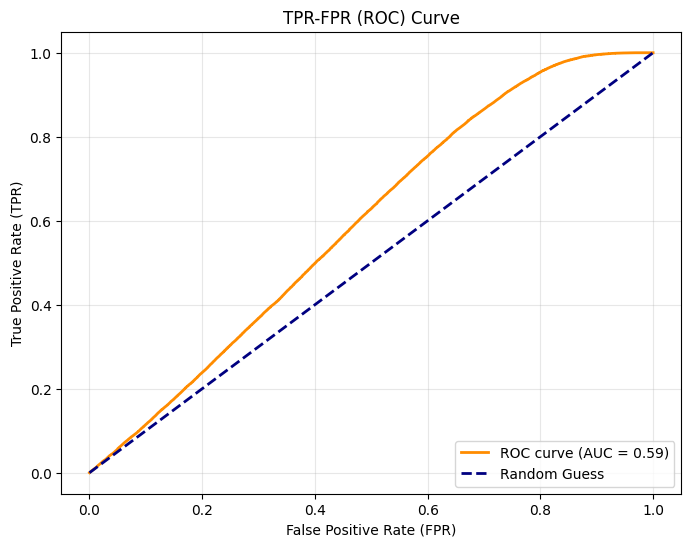

{'fpr': array([0.00000000e+00, 7.00000000e-04, 1.50000000e-03, ...,
        9.80500000e-01, 9.80533333e-01, 1.00000000e+00]),
 'tpr': array([0.00000000e+00, 9.66666667e-04, 1.63333333e-03, ...,
        9.99966667e-01, 1.00000000e+00, 1.00000000e+00]),
 'auc': 0.5927448294444444,
 'one_fpr': 0.010633333333333333,
 'one_tenth_fpr': 0.0009666666666666667,
 'zero_fpr': 0.0,
 'thresholds': array([          inf, 1.0000000e+00, 9.9999988e-01, ..., 3.0645789e-03,
        3.0456509e-03, 1.1216170e-08], dtype=float32)}

In [33]:
attack_p_res_ann = compute_attack_results(attack_p_score_ann, target_memberships)
visualization(attack_p_res_ann)
attack_p_res_ann

### Attack_p on snn

In [34]:
#attack_r_score_ann = compute_confidence_ann(target_model_ann, full_loader, device)
attack_p_score_snn = compute_confidence_snn(target_model_snn, full_loader, device, n_steps)

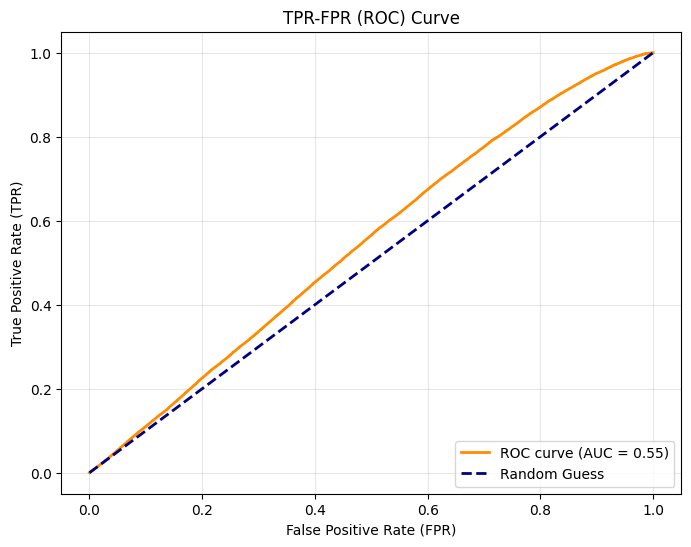

{'fpr': array([0.00000000e+00, 3.33333333e-05, 6.66666667e-05, ...,
        9.99833333e-01, 9.99866667e-01, 1.00000000e+00]),
 'tpr': array([0.00000000e+00, 3.33333333e-05, 3.33333333e-05, ...,
        9.99966667e-01, 1.00000000e+00, 1.00000000e+00]),
 'auc': 0.5466446211111111,
 'one_fpr': 0.010233333333333334,
 'one_tenth_fpr': 0.0011333333333333334,
 'zero_fpr': 0.0,
 'thresholds': array([          inf, 9.9995029e-01, 9.9994755e-01, ..., 2.4368263e-05,
        2.0421701e-05, 5.5522123e-06], dtype=float32)}

In [35]:
attack_p_res_snn = compute_attack_results(attack_p_score_snn, target_memberships)
visualization(attack_p_res_snn)
attack_p_res_snn


### layer dropout Attack_p on ann 

In [36]:
# grid search for the best dropout rate
for rate in [0.01, 0.02, 0.03, 0.04, 0.05, 0.06]:
    input_dropout_fn = generate_input_dropout_fn(rate)
    dropout_attack_p_score_ann = compute_cali_confidence_ann(target_model_ann, full_loader, device, input_dropout_fn, n_samples=5)
    dropout_attack_p_res_ann = compute_attack_results(dropout_attack_p_score_ann, target_memberships)
    print(f"Dropout rate: {rate}, AUC: {dropout_attack_p_res_ann['auc']:.4f}")

Dropout rate: 0.01, AUC: 0.5891
Dropout rate: 0.02, AUC: 0.5840
Dropout rate: 0.03, AUC: 0.5777
Dropout rate: 0.04, AUC: 0.5724
Dropout rate: 0.05, AUC: 0.5661
Dropout rate: 0.06, AUC: 0.5593


In [37]:
input_dropout_fn = generate_input_dropout_fn(0.01)
dropout_attack_p_score_ann = compute_cali_confidence_ann(target_model_ann, full_loader, device, input_dropout_fn, n_samples=5)

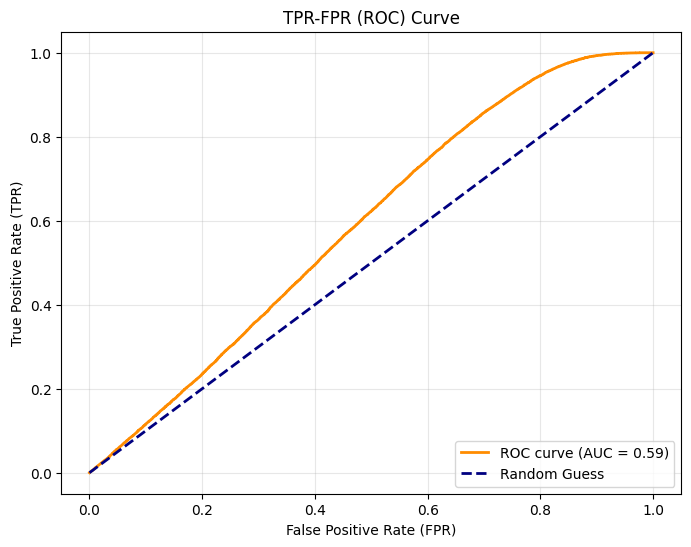

In [38]:
dropout_attack_p_res_ann = compute_attack_results(dropout_attack_p_score_ann, target_memberships)
visualization(dropout_attack_p_res_ann)

layer dropout is not work for attack p on ann.

### layer dropout Attack_p on snn 

In [39]:
# grid search for the best dropout rate
for rate in [0.01, 0.02, 0.03, 0.04, 0.05, 0.06]:
    input_dropout_fn = generate_input_dropout_fn(rate)
    dropout_attack_p_score_snn = compute_cali_confidence_snn(target_model_snn, full_loader, device, n_steps, input_dropout_fn, n_samples=5)
    dropout_attack_p_res_snn = compute_attack_results(dropout_attack_p_score_snn, target_memberships)
    print(f"Dropout rate: {rate}, AUC: {dropout_attack_p_res_snn['auc']:.2f}")

Dropout rate: 0.01, AUC: 0.55
Dropout rate: 0.02, AUC: 0.54
Dropout rate: 0.03, AUC: 0.54
Dropout rate: 0.04, AUC: 0.54
Dropout rate: 0.05, AUC: 0.54
Dropout rate: 0.06, AUC: 0.53


In [40]:
# for snn
input_dropout_fn = generate_input_dropout_fn(0.01)
dropout_attack_p_score_snn = compute_cali_confidence_snn(target_model_snn, full_loader, device, n_steps, input_dropout_fn, n_samples=5)

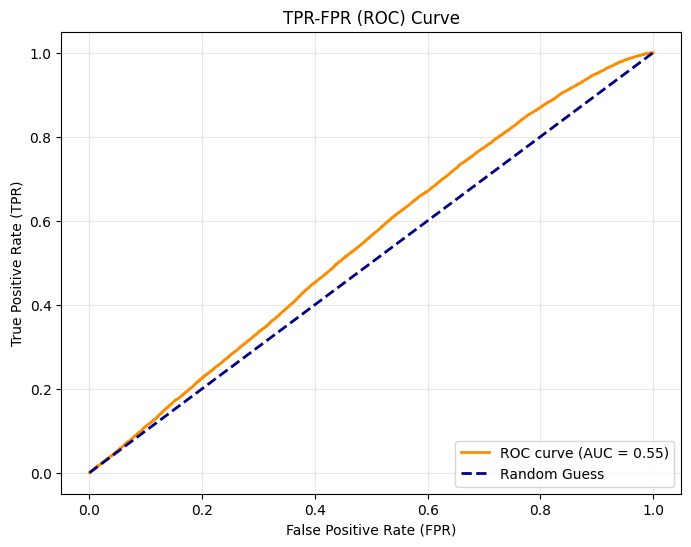

In [41]:
dropout_attack_p_res_snn = compute_attack_results(dropout_attack_p_score_snn, target_memberships)
visualization(dropout_attack_p_res_snn)

In [42]:
print(len(set(attack_p_score_ann)))

print(len(set(attack_p_score_snn)))

41345
44838


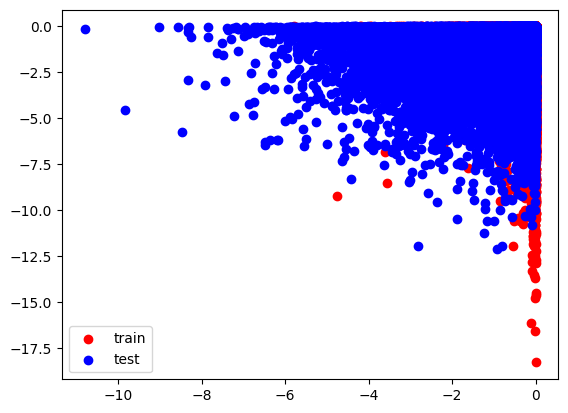

In [43]:
# plot a 2d graph for the attack scores of ann and snn
attack_p_score_ann_train , attack_p_score_ann_test =  np.log(attack_p_score_ann[:30000]) , np.log(attack_p_score_snn[:30000])
attack_p_score_snn_train , attack_p_score_snn_test =  np.log(attack_p_score_ann[30000:]) , np.log(attack_p_score_snn[30000:])

#horizantal axis is ann and vertical axis is ann
plt.scatter(attack_p_score_ann_train, attack_p_score_snn_train, c='r', label='train')
plt.scatter(attack_p_score_ann_test, attack_p_score_snn_test, c='b', label='test')
plt.legend()
plt.show()


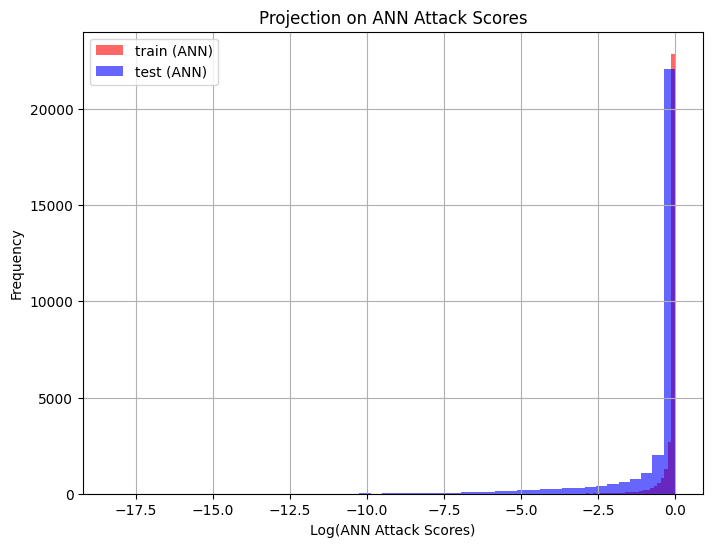

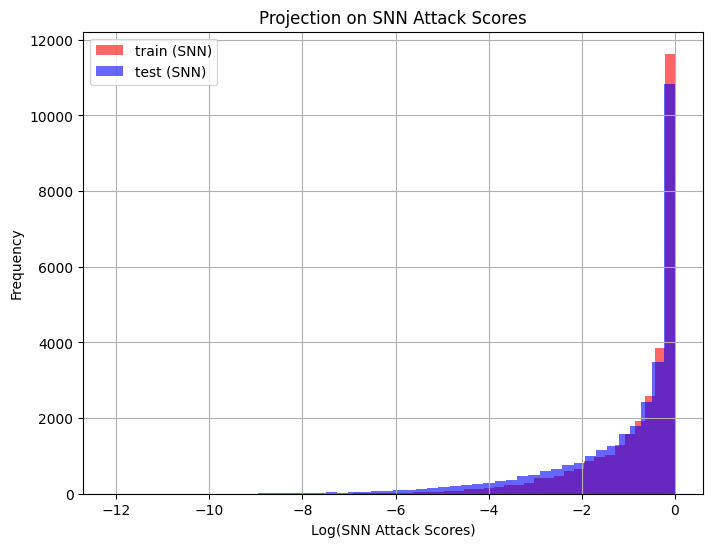

In [44]:
import numpy as np
import matplotlib.pyplot as plt


attack_p_score_ann_train, attack_p_score_ann_test = np.log(attack_p_score_ann[:30000]), np.log(attack_p_score_ann[30000:])
attack_p_score_snn_train, attack_p_score_snn_test = np.log(attack_p_score_snn[:30000]), np.log(attack_p_score_snn[30000:])

plt.figure(figsize=(8, 6))
plt.hist(attack_p_score_ann_train, bins=50, color='r', alpha=0.6, label='train (ANN)')
plt.hist(attack_p_score_ann_test, bins=50, color='b', alpha=0.6, label='test (ANN)')
plt.title("Projection on ANN Attack Scores")
plt.xlabel("Log(ANN Attack Scores)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.hist(attack_p_score_snn_train, bins=50, color='r', alpha=0.6, label='train (SNN)')
plt.hist(attack_p_score_snn_test, bins=50, color='b', alpha=0.6, label='test (SNN)')
plt.title("Projection on SNN Attack Scores")
plt.xlabel("Log(SNN Attack Scores)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()


## Attack R


In [45]:
def attack_r_ann(target_model_ann, reference_models, dataset, device, batch_size=64):


    compute_confidence = compute_confidence_ann
    # Create dataloader for the dataset
    full_loader = get_dataloader_from_dataset(DATASET, Subset(dataset, np.concatenate((train_idxs, test_idxs), axis=0)), batch_size=BATCH_SIZE, train=False)

    # Set the target model to evaluation mode
    target_model_ann.eval()

    for ref_model in reference_models:
        ref_model.eval()  # Set reference models to evaluation mode

    target_confidences = compute_confidence(target_model_ann, full_loader, device)
    reference_confidences = np.array([
        compute_confidence(ref_model, full_loader, device)
        for ref_model in reference_models
    ])

    # Compute ratios Pr(x|θ) / Pr(x|θ') for all samples in parallel
    target_confidences = np.expand_dims(target_confidences, axis=0)  # Shape: (1, N_samples)
    ratios = target_confidences / reference_confidences  # Shape: (num_reference_models, N_samples)

    # Check if ratio >= 1 for each sample and each reference model
    satisfied_conditions = (ratios >= 1).astype(np.float32)  # Shape: (num_reference_models, N_samples)

    # Compute Attack-R scores as the mean of satisfied conditions across reference models
    attack_r_scores = np.mean(satisfied_conditions, axis=0)  # Shape: (N_samples,)

    return attack_r_scores


def attack_r_snn(target_model_ann, reference_models, dataset, device, n_steps, batch_size=64):

    compute_confidence = compute_confidence_snn

    # Create dataloader for the dataset
    full_loader = get_dataloader_from_dataset(DATASET, Subset(dataset, np.concatenate((train_idxs, test_idxs), axis=0)), batch_size=BATCH_SIZE, train=False)

    # Set the target model to evaluation mode
    target_model_ann.eval()

    for ref_model in reference_models:
        ref_model.eval()  # Set reference models to evaluation mode

    target_confidences = compute_confidence_snn(target_model_ann, full_loader, device, n_steps)
    reference_confidences = np.array([
        compute_confidence_snn(ref_model, full_loader, device,n_steps)
        for ref_model in reference_models
    ])

    # Compute ratios Pr(x|θ) / Pr(x|θ') for all samples in parallel
    target_confidences = np.expand_dims(target_confidences, axis=0)  # Shape: (1, N_samples)
    ratios = target_confidences / reference_confidences  # Shape: (num_reference_models, N_samples)

    # Check if ratio >= 1 for each sample and each reference model
    satisfied_conditions = (ratios >= 1).astype(np.float32)  # Shape: (num_reference_models, N_samples)

    # Compute Attack-R scores as the mean of satisfied conditions across reference models
    attack_r_scores = np.mean(satisfied_conditions, axis=0)  # Shape: (N_samples,)

    return attack_r_scores

### Attack-R for ann

In [46]:
# Compute Attack-R scores for the ann model
attack_r_scores_ann = attack_r_ann(target_model_ann, reference_models_anns, dataset, device, batch_size=64)

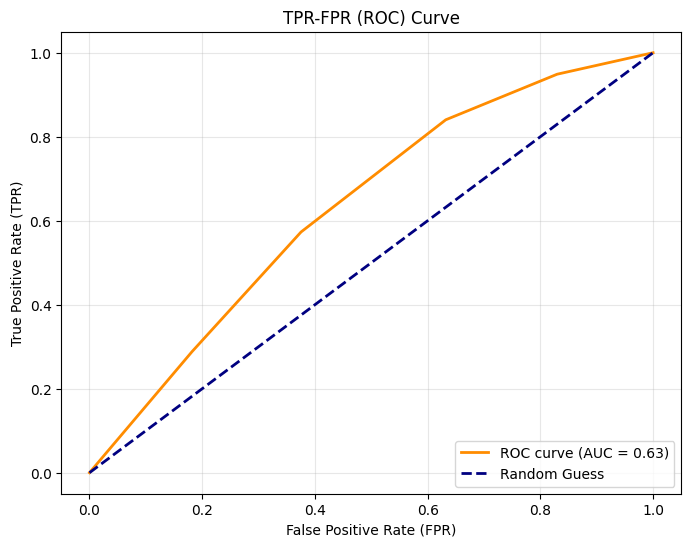

{'fpr': array([0.        , 0.18196667, 0.37536667, 0.63213333, 0.82976667,
        1.        ]),
 'tpr': array([0.        , 0.28826667, 0.57313333, 0.8403    , 0.94883333,
        1.        ]),
 'auc': 0.6336605144444445,
 'one_fpr': 0.0,
 'one_tenth_fpr': 0.0,
 'zero_fpr': 0.0,
 'thresholds': array([ inf, 1.  , 0.75, 0.5 , 0.25, 0.  ], dtype=float32)}

In [47]:
# Compute Attack-R results
attack_r_res_ann = compute_attack_results(attack_r_scores_ann, target_memberships)
visualization(attack_r_res_ann)
attack_r_res_ann

### Attack-R for snn

In [48]:
# Compute Attack-R scores for the snn model
attack_r_scores_snn = attack_r_snn(target_model_snn, reference_models_snn, dataset, device, n_steps, batch_size=64)

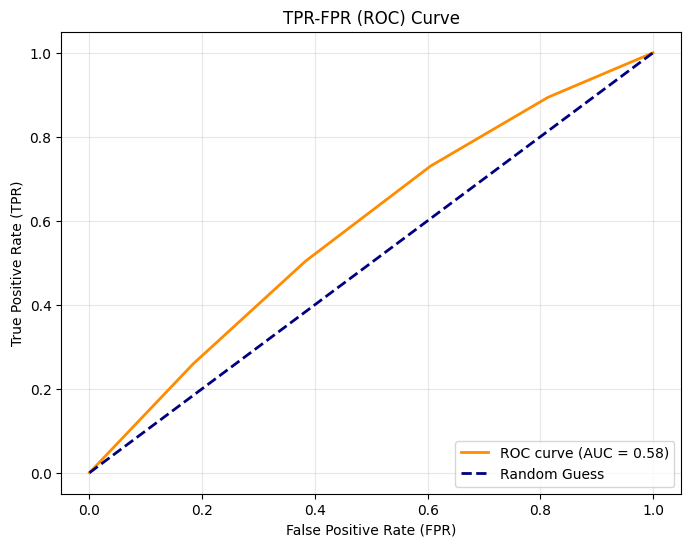

{'fpr': array([0.        , 0.18386667, 0.38366667, 0.60553333, 0.8136    ,
        1.        ]),
 'tpr': array([0.        , 0.25896667, 0.50413333, 0.73043333, 0.89386667,
        1.        ]),
 'auc': 0.5824856711111112,
 'one_fpr': 0.0,
 'one_tenth_fpr': 0.0,
 'zero_fpr': 0.0,
 'thresholds': array([ inf, 1.  , 0.75, 0.5 , 0.25, 0.  ], dtype=float32)}

In [49]:
# Compute Attack-R results
attack_r_res_snn = compute_attack_results(attack_r_scores_snn, target_memberships)
visualization(attack_r_res_snn)
attack_r_res_snn

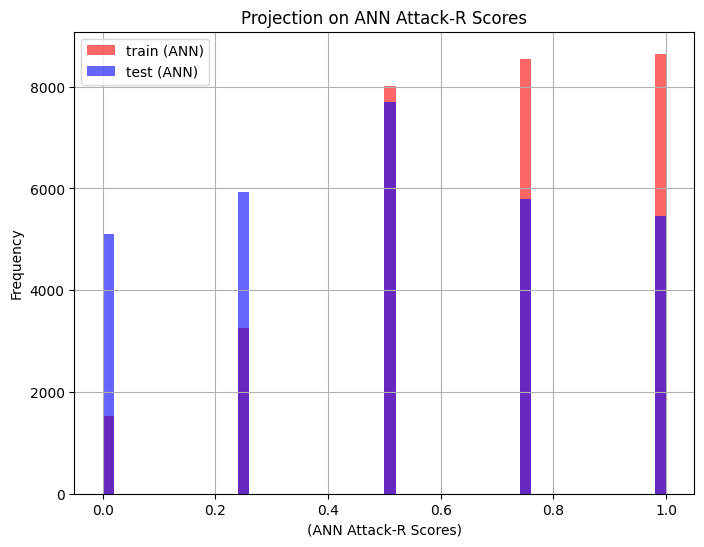

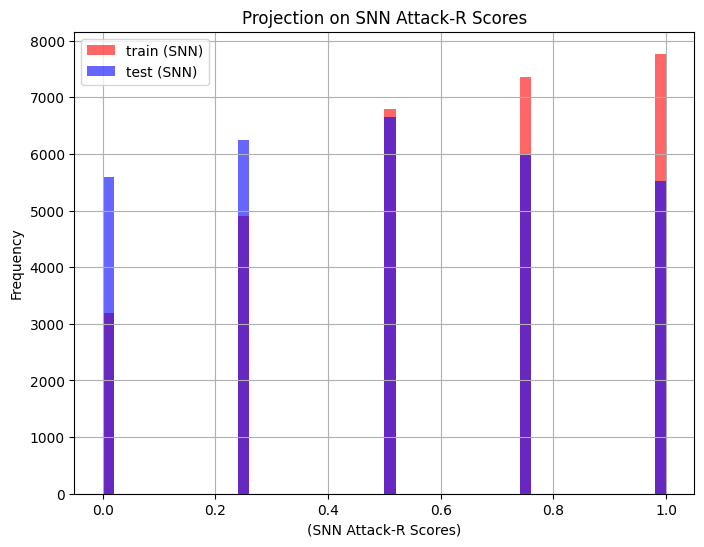

In [50]:


attack_r_score_ann_train, attack_r_score_ann_test = (attack_r_scores_ann[:30000]), (attack_r_scores_ann[30000:])
attack_r_score_snn_train, attack_r_score_snn_test = (attack_r_scores_snn[:30000]), (attack_r_scores_snn[30000:])
# ann
plt.figure(figsize=(8, 6))
plt.hist(attack_r_score_ann_train, bins=50, color='r', alpha=0.6, label='train (ANN)')
plt.hist(attack_r_score_ann_test, bins=50, color='b', alpha=0.6, label='test (ANN)')
plt.title("Projection on ANN Attack-R Scores")
plt.xlabel("(ANN Attack-R Scores)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

# snn
plt.figure(figsize=(8, 6))
plt.hist(attack_r_score_snn_train, bins=50, color='r', alpha=0.6, label='train (SNN)')
plt.hist(attack_r_score_snn_test, bins=50, color='b', alpha=0.6, label='test (SNN)')
plt.title("Projection on SNN Attack-R Scores")
plt.xlabel("(SNN Attack-R Scores)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()







# input dropout enhence of attack_r

In [51]:
def cali_attack_r_ann(target_model_ann, reference_models, dataset, device, augment_fn, n_samples=5, batch_size=64):


    compute_confidence = compute_cali_confidence_ann
    # Create dataloader for the dataset
    full_loader = get_dataloader_from_dataset(DATASET, Subset(dataset, np.concatenate((train_idxs, test_idxs), axis=0)), batch_size=BATCH_SIZE, train=False)

    # Set the target model to evaluation mode
    target_model_ann.eval()

    for ref_model in reference_models:
        ref_model.eval()  # Set reference models to evaluation mode

    target_confidences = compute_confidence(target_model_ann, full_loader, device, augment_fn, n_samples)
    reference_confidences = np.array([
        compute_confidence(ref_model, full_loader, device, augment_fn, n_samples)
        for ref_model in reference_models
    ])

    # Compute ratios Pr(x|θ) / Pr(x|θ') for all samples in parallel
    target_confidences = np.expand_dims(target_confidences, axis=0)  # Shape: (1, N_samples)
    ratios = target_confidences / reference_confidences  # Shape: (num_reference_models, N_samples)

    # Check if ratio >= 1 for each sample and each reference model
    satisfied_conditions = (ratios >= 1).astype(np.float32)  # Shape: (num_reference_models, N_samples)

    # Compute Attack-R scores as the mean of satisfied conditions across reference models
    attack_r_scores = np.mean(satisfied_conditions, axis=0)  # Shape: (N_samples,)

    return attack_r_scores




def cali_attack_r_snn(target_model_snn, reference_models, dataset, device, augment_fn, n_steps, n_samples=5, batch_size=64):


    compute_confidence = compute_cali_confidence_snn
    # Create dataloader for the dataset
    full_loader = get_dataloader_from_dataset(DATASET, Subset(dataset, np.concatenate((train_idxs, test_idxs), axis=0)), batch_size=BATCH_SIZE, train=False)

    # Set the target model to evaluation mode
    target_model_ann.eval()

    for ref_model in reference_models:
        ref_model.eval()  # Set reference models to evaluation mode

    target_confidences = compute_confidence(target_model_snn, full_loader, device, n_steps, augment_fn, n_samples)
    reference_confidences = np.array([
        compute_confidence(ref_model, full_loader, device, n_steps,  augment_fn, n_samples)
        for ref_model in reference_models
    ])

    # Compute ratios Pr(x|θ) / Pr(x|θ') for all samples in parallel
    target_confidences = np.expand_dims(target_confidences, axis=0)  # Shape: (1, N_samples)
    ratios = target_confidences / reference_confidences  # Shape: (num_reference_models, N_samples)

    # Check if ratio >= 1 for each sample and each reference model
    satisfied_conditions = (ratios >= 1).astype(np.float32)  # Shape: (num_reference_models, N_samples)

    # Compute Attack-R scores as the mean of satisfied conditions across reference models
    attack_r_scores = np.mean(satisfied_conditions, axis=0)  # Shape: (N_samples,)

    return attack_r_scores



### input dropout enhence of attack_r on ann 

In [52]:
# grid search for the best dropout rate for ann 
for rate in [0.01, 0.02, 0.03, 0.04, 0.05, 0.06]:
    input_dropout_fn = generate_input_dropout_fn(rate)
    cali_attack_r_score_ann = cali_attack_r_ann(target_model_ann, reference_models_anns, dataset, device, input_dropout_fn, n_samples=5)
    cali_attack_r_res_ann = compute_attack_results(cali_attack_r_score_ann, target_memberships)
    print(f"Dropout rate: {rate}, AUC: {cali_attack_r_res_ann['auc']:.2f}")


KeyboardInterrupt: 

In [241]:
# for ann model cali_attack_r_ann
input_dropout_fn = generate_input_dropout_fn(0.01)
cali_attack_r_score_ann = cali_attack_r_ann(target_model_ann, reference_models_anns, dataset, device, input_dropout_fn, n_samples=5)


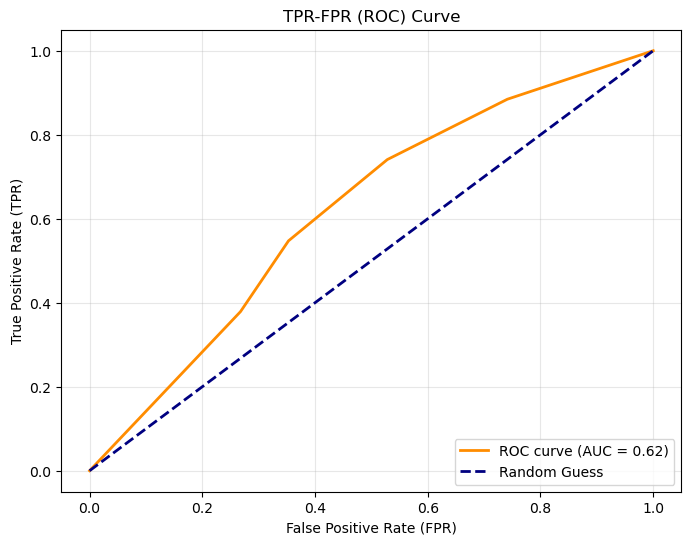

{'fpr': array([0.        , 0.26773333, 0.35293333, 0.52826667, 0.74116667,
        1.        ]),
 'tpr': array([0.        , 0.37876667, 0.54736667, 0.74086667, 0.8845    ,
        1.        ]),
 'auc': 0.6199986233333333,
 'one_fpr': 0.0,
 'one_tenth_fpr': 0.0,
 'zero_fpr': 0.0,
 'thresholds': array([ inf, 1.  , 0.75, 0.5 , 0.25, 0.  ], dtype=float32)}

In [242]:
 # compute_attack_results
cali_attack_r_res_ann = compute_attack_results(cali_attack_r_score_ann, target_memberships)
visualization(cali_attack_r_res_ann)
cali_attack_r_res_ann

### input dropout enhence of attack_r on snn

In [253]:
# grid search for the best dropout rate for snn
for rate in [0.01, 0.02, 0.03, 0.04, 0.05, 0.06]:
    input_dropout_fn = generate_input_dropout_fn(rate)
    cali_attack_r_score_snn = cali_attack_r_snn(target_model_snn, reference_models_snn, dataset, device, input_dropout_fn, n_steps, n_samples=5)
    cali_attack_r_res_snn = compute_attack_results(cali_attack_r_score_snn, target_memberships)
    print(f"Dropout rate: {rate}, AUC: {cali_attack_r_res_snn['auc']:.2f}")

Dropout rate: 0.01, AUC: 0.61
Dropout rate: 0.02, AUC: 0.60
Dropout rate: 0.03, AUC: 0.59
Dropout rate: 0.04, AUC: 0.58
Dropout rate: 0.05, AUC: 0.58
Dropout rate: 0.06, AUC: 0.57


In [321]:
# for snn model cali_attack_r_snn
input_dropout_fn = generate_input_dropout_fn(0.01)
cali_attack_r_score_snn = cali_attack_r_snn(target_model_snn, reference_models_snn, dataset, device, input_dropout_fn, n_steps, n_samples=10)

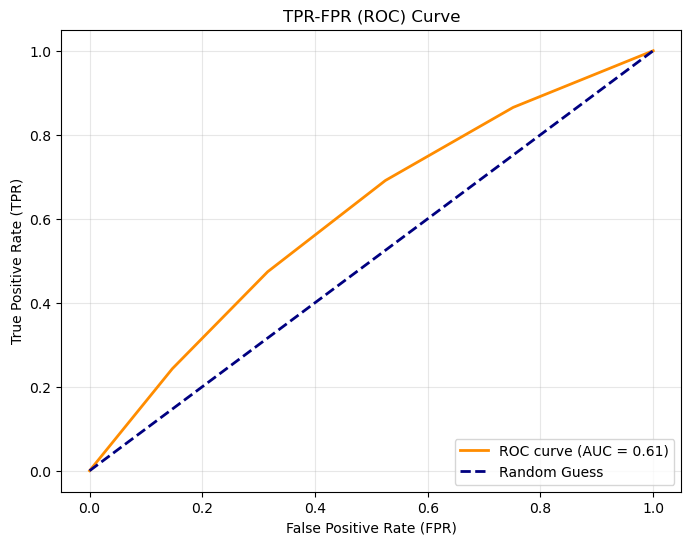

{'fpr': array([0.        , 0.1468    , 0.31596667, 0.52486667, 0.7515    ,
        1.        ]),
 'tpr': array([0.        , 0.24286667, 0.47376667, 0.69106667, 0.86506667,
        1.        ]),
 'auc': 0.6081788666666667,
 'one_fpr': 0.0,
 'one_tenth_fpr': 0.0,
 'zero_fpr': 0.0,
 'thresholds': array([ inf, 1.  , 0.75, 0.5 , 0.25, 0.  ], dtype=float32)}

In [322]:
 # compute_attack_results for snn
cali_attack_r_res_snn = compute_attack_results(cali_attack_r_score_snn, target_memberships)
visualization(cali_attack_r_res_snn)
cali_attack_r_res_snn

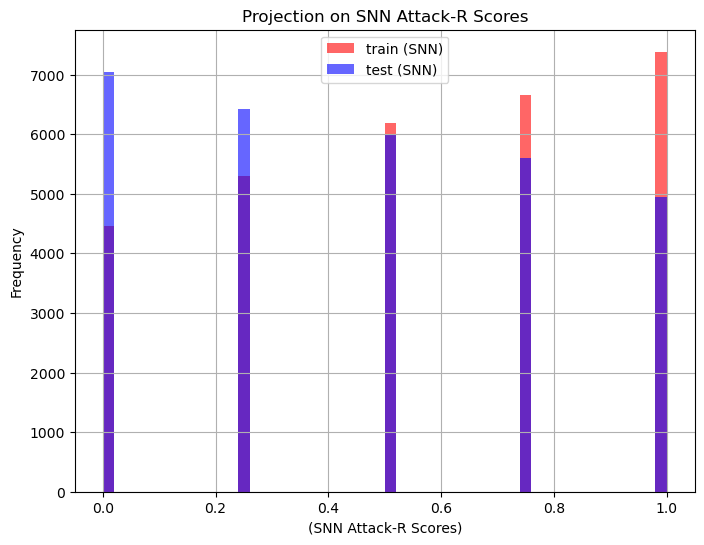

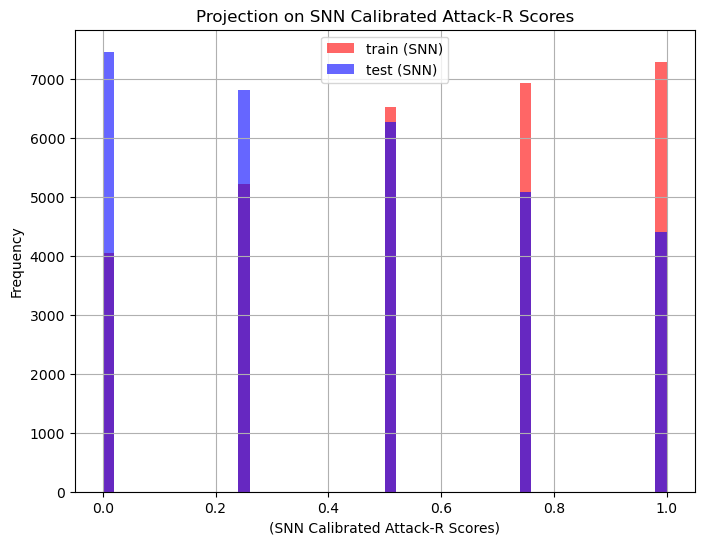

In [323]:
attack_r_score_snn_train, attack_r_score_snn_test = (attack_r_scores_snn[:30000]), (attack_r_scores_snn[30000:])
cali_attack_r_res_snn_train, cali_attack_r_res_snn_test = (cali_attack_r_score_snn[:30000]), (cali_attack_r_score_snn[30000:])
# snn
plt.figure(figsize=(8, 6))
plt.hist(attack_r_score_snn_train, bins=50, color='r', alpha=0.6, label='train (SNN)')
plt.hist(attack_r_score_snn_test, bins=50, color='b', alpha=0.6, label='test (SNN)')
plt.title("Projection on SNN Attack-R Scores")
plt.xlabel("(SNN Attack-R Scores)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.hist(cali_attack_r_res_snn_train, bins=50, color='r', alpha=0.6, label='train (SNN)')
plt.hist(cali_attack_r_res_snn_test, bins=50, color='b', alpha=0.6, label='test (SNN)')
plt.title("Projection on SNN Calibrated Attack-R Scores")
plt.xlabel("(SNN Calibrated Attack-R Scores)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

# using the input dropout on attack r improve the attack on snn

# RMIA

In [57]:
def rmia_ann(target_model, reference_models, dataset, device, gamma=1.0, batch_size=64):
    """
    Compute the MIA score for a target model using parallel computation.

    Args:
        target_model: The target model (θ).
        reference_models: List of reference models (θ').
        dataset: The dataset containing samples (used for both x and z).
        device: The device (CPU/GPU) to run computations on.
        gamma: Threshold value for the ratio comparison.
        batch_size: Batch size for the dataloader.

    Returns:
        mia_scores: List of MIA scores for each sample in the dataset.
    """
    compute_confidence = compute_confidence_ann

    # Create a dataloader for the dataset
    full_loader = get_dataloader_from_dataset(DATASET, Subset(dataset, np.concatenate((train_idxs, test_idxs), axis=0)), batch_size=BATCH_SIZE, train=False)

    # Compute Pr(x|θ) for the target model
    target_confidences = compute_confidence(target_model, full_loader, device)  # Shape: (N,)
    target_confidences = target_confidences

    # Compute Pr(x|θ') for all reference models
    reference_confidences = np.array([
        compute_confidence(ref_model, full_loader, device)
        for ref_model in reference_models
    ])  # Shape: (num_reference_models, N)

    # Compute Pr(x) as the average over reference models
    pr_x = np.mean(reference_confidences, axis=0)  # Shape: (N,)

    # Compute Ratio_x for each x in the dataset
    ratio_x = target_confidences / pr_x  # Shape: (N,)

    # # Compute the ratio matrix for all (x, z) pairs
    # ratio_matrix = ratio_x[:, None] / ratio_x[None, :]  # Shape: (N, N)

    # # Check where the condition is satisfied
    # satisfied_matrix = ratio_matrix >= gamma  # Shape: (N, N)

    # # Compute MIA scores as the proportion of satisfied conditions for each x
    # mia_scores = np.mean(satisfied_matrix, axis=1)  # Shape: (N,)

    return ratio_x


def rmia_snn(target_model, reference_models, dataset, device, n_steps, gamma=1.0, batch_size=64):
    """
    Compute the MIA score for a target model using parallel computation.

    Args:
        target_model: The target model (θ).
        reference_models: List of reference models (θ').
        dataset: The dataset containing samples (used for both x and z).
        device: The device (CPU/GPU) to run computations on.
        gamma: Threshold value for the ratio comparison.
        batch_size: Batch size for the dataloader.

    Returns:
        mia_scores: List of MIA scores for each sample in the dataset.
    """
    compute_confidence = compute_confidence_snn

    # Create a dataloader for the dataset
    full_loader = get_dataloader_from_dataset(DATASET, Subset(dataset, np.concatenate((train_idxs, test_idxs), axis=0)), batch_size=BATCH_SIZE, train=False)

    # Compute Pr(x|θ) for the target model
    target_confidences = compute_confidence(target_model, full_loader, device,  n_steps)  # Shape: (N,)
    target_confidences = target_confidences

    # Compute Pr(x|θ') for all reference models
    reference_confidences = np.array([
        compute_confidence(ref_model, full_loader, device,  n_steps)
        for ref_model in reference_models
    ])  # Shape: (num_reference_models, N)

    # Compute Pr(x) as the average over reference models
    pr_x = np.mean(reference_confidences, axis=0)  # Shape: (N,)

    # Compute Ratio_x for each x in the dataset
    ratio_x = target_confidences / pr_x  # Shape: (N,)

    # # Compute the ratio matrix for all (x, z) pairs
    # ratio_matrix = ratio_x[:, None] / ratio_x[None, :]  # Shape: (N, N)

    # # Check where the condition is satisfied
    # satisfied_matrix = ratio_matrix >= gamma  # Shape: (N, N)

    # # Compute MIA scores as the proportion of satisfied conditions for each x
    # mia_scores = np.mean(satisfied_matrix, axis=1)  # Shape: (N,)

    return ratio_x

### rmia for ann

In [258]:
# Compute RMIA scores for the ann model
rmia_scores_ann = rmia_ann(target_model_ann, reference_models_anns, dataset, device, gamma=1.0, batch_size=64)


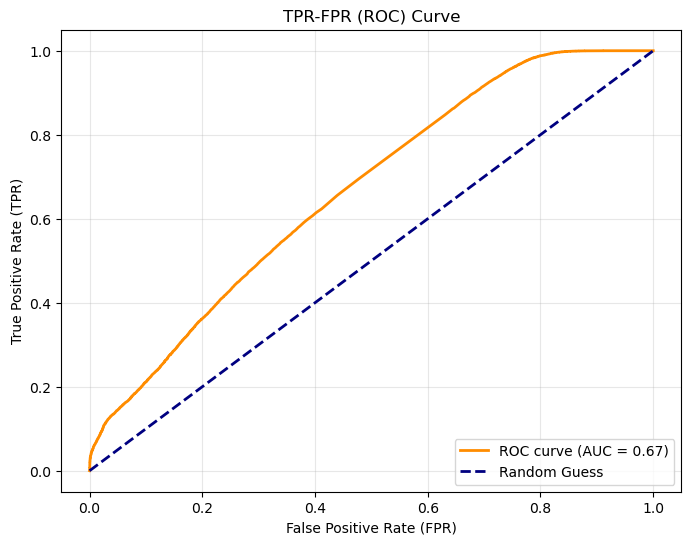

{'fpr': array([0.00000000e+00, 3.33333333e-05, 3.33333333e-05, ...,
        9.42133333e-01, 9.42133333e-01, 1.00000000e+00]),
 'tpr': array([0.00000000e+00, 0.00000000e+00, 2.00000000e-04, ...,
        9.99966667e-01, 1.00000000e+00, 1.00000000e+00]),
 'auc': 0.6663185027777778,
 'one_fpr': 0.0643,
 'one_tenth_fpr': 0.0297,
 'zero_fpr': 0.0,
 'thresholds': array([           inf, 1.00000000e+00, 9.99900000e-01, ...,
        2.89666667e-02, 2.89500000e-02, 1.66666667e-05])}

In [259]:
# Compute RMIA results
rmia_res_ann = compute_attack_results(rmia_scores_ann, target_memberships)
visualization(rmia_res_ann)
rmia_res_ann

### rmia for snn

In [266]:
# Compute RMIA scores for the snn model
rmia_scores_snn = rmia_snn(target_model_snn, reference_models_snn, dataset, device, n_steps, gamma=1.0, batch_size=64)

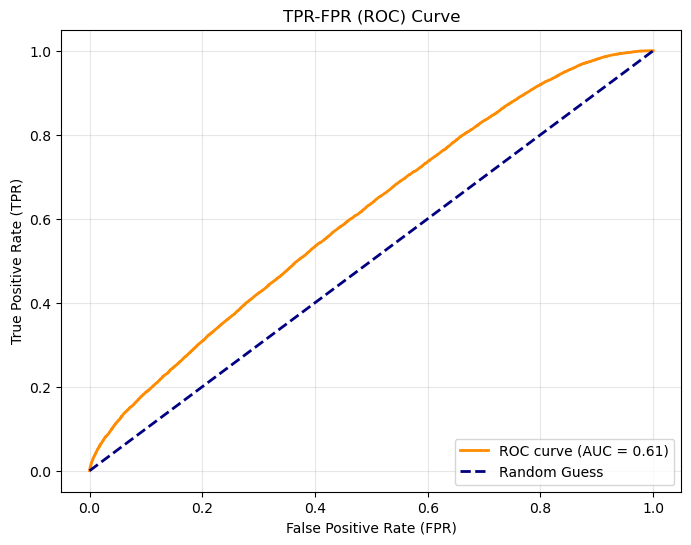

{'fpr': array([0.        , 0.        , 0.        , ..., 0.99843333, 0.99843333,
        1.        ]),
 'tpr': array([0.00000000e+00, 3.33333333e-05, 1.00000000e-04, ...,
        9.99966667e-01, 1.00000000e+00, 1.00000000e+00]),
 'auc': 0.6084679016666668,
 'one_fpr': 0.03866666666666667,
 'one_tenth_fpr': 0.0074,
 'zero_fpr': 0.0001,
 'thresholds': array([          inf, 3.3627646e+02, 1.0903852e+02, ..., 1.2309041e-03,
        1.1952991e-03, 1.7436341e-04], dtype=float32)}

In [267]:
# Compute RMIA results
rmia_res_snn = compute_attack_results(rmia_scores_snn, target_memberships)
visualization(rmia_res_snn)
rmia_res_snn

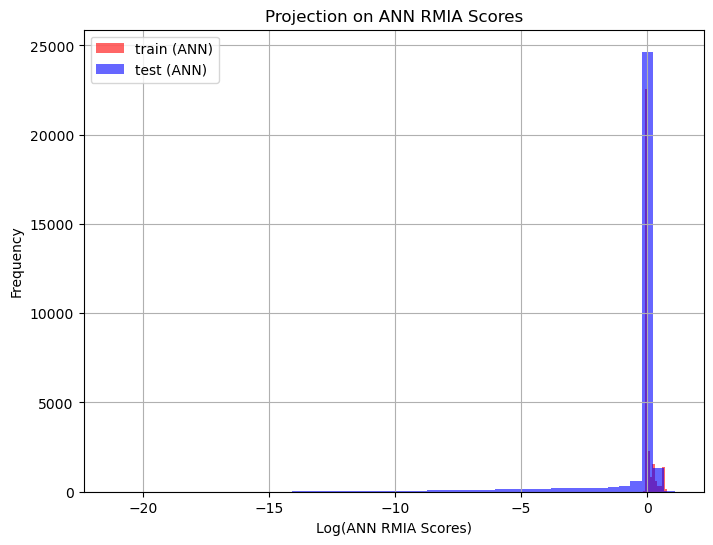

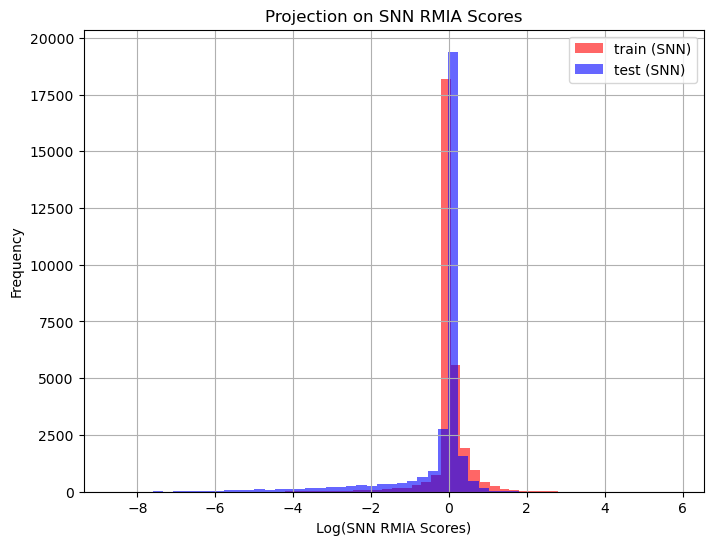

In [288]:

rmia_score_ann_train, rmia_score_ann_test = np.log(rmia_scores_ann[:30000]), np.log(rmia_scores_ann[30000:])
rmia_score_snn_train, rmia_score_snn_test = np.log(rmia_scores_snn[:30000]), np.log(rmia_scores_snn[30000:])
# ann
plt.figure(figsize=(8, 6))
plt.hist(rmia_score_ann_train, bins=50, color='r', alpha=0.6, label='train (ANN)')
plt.hist(rmia_score_ann_test, bins=50, color='b', alpha=0.6, label='test (ANN)')
plt.title("Projection on ANN RMIA Scores")
plt.xlabel("Log(ANN RMIA Scores)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

# snn
plt.figure(figsize=(8, 6))
plt.hist(rmia_score_snn_train, bins=50, color='r', alpha=0.6, label='train (SNN)')
plt.hist(rmia_score_snn_test, bins=50, color='b', alpha=0.6, label='test (SNN)')
plt.title("Projection on SNN RMIA Scores")
plt.xlabel("Log(SNN RMIA Scores)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()


## Enhence rmia by input droupout

In [279]:
def cali_rmia_ann(target_model, reference_models, dataset, device, augment_fn, n_samples=5, gamma=1.0, batch_size=64):
    """
    Compute the MIA score for a target model using parallel computation.

    Args:
        target_model: The target model (θ).
        reference_models: List of reference models (θ').
        dataset: The dataset containing samples (used for both x and z).
        device: The device (CPU/GPU) to run computations on.
        gamma: Threshold value for the ratio comparison.
        batch_size: Batch size for the dataloader.

    Returns:
        mia_scores: List of MIA scores for each sample in the dataset.
    """
    compute_confidence = compute_cali_confidence_ann

    # Create a dataloader for the dataset
    full_loader = get_dataloader_from_dataset(DATASET, Subset(dataset, np.concatenate((train_idxs, test_idxs), axis=0)), batch_size=BATCH_SIZE, train=False)

    # Compute Pr(x|θ) for the target model
    target_confidences = compute_confidence(target_model_ann, full_loader, device, augment_fn, n_samples)  # Shape: (N,)
    target_confidences = target_confidences

    # Compute Pr(x|θ') for all reference models
    reference_confidences = np.array([
        compute_confidence(ref_model, full_loader, device, augment_fn, n_samples)
        for ref_model in reference_models
    ])  # Shape: (num_reference_models, N)

    # Compute Pr(x) as the average over reference models
    pr_x = np.mean(reference_confidences, axis=0)  # Shape: (N,)

    # Compute Ratio_x for each x in the dataset
    ratio_x = target_confidences / pr_x  # Shape: (N,)

    # # Compute the ratio matrix for all (x, z) pairs
    # ratio_matrix = ratio_x[:, None] / ratio_x[None, :]  # Shape: (N, N)

    # # Check where the condition is satisfied
    # satisfied_matrix = ratio_matrix >= gamma  # Shape: (N, N)

    # # Compute MIA scores as the proportion of satisfied conditions for each x
    # mia_scores = np.mean(satisfied_matrix, axis=1)  # Shape: (N,)

    return ratio_x






def cali_rmia_snn(target_model, reference_models, dataset, device, n_steps, augment_fn, n_samples=50, gamma=1.0, batch_size=64):
    """
    Compute the MIA score for a target model using parallel computation.

    Args:
        target_model: The target model (θ).
        reference_models: List of reference models (θ').
        dataset: The dataset containing samples (used for both x and z).
        device: The device (CPU/GPU) to run computations on.
        gamma: Threshold value for the ratio comparison.
        batch_size: Batch size for the dataloader.

    Returns:
        mia_scores: List of MIA scores for each sample in the dataset.
    """
    compute_confidence =compute_cali_confidence_snn

    # Create a dataloader for the dataset
    full_loader = get_dataloader_from_dataset(DATASET, dSubset(dataset, np.concatenate((train_idxs, test_idxs), axis=0)), batch_size=BATCH_SIZE, train=False)

    # Compute Pr(x|θ) for the target model
    target_confidences = compute_confidence(target_model_snn, full_loader, device, n_steps, augment_fn, n_samples)  # Shape: (N,)
    # target_confidences = target_confidences.cpu().numpy()

    # Compute Pr(x|θ') for all reference models
    reference_confidences = np.array([
        compute_confidence(ref_model, full_loader, device, n_steps,  augment_fn, n_samples)
        for ref_model in reference_models
    ])  # Shape: (num_reference_models, N)

    # Compute Pr(x) as the average over reference models
    pr_x = np.mean(reference_confidences, axis=0)  # Shape: (N,)

    # Compute Ratio_x for each x in the dataset
    ratio_x = target_confidences / pr_x  # Shape: (N,)

    # # Compute the ratio matrix for all (x, z) pairs
    # ratio_matrix = ratio_x[:, None] / ratio_x[None, :]  # Shape: (N, N)

    # # Check where the condition is satisfied
    # satisfied_matrix = ratio_matrix >= gamma  # Shape: (N, N)

    # # Compute MIA scores as the proportion of satisfied conditions for each x
    # mia_scores = np.mean(satisfied_matrix, axis=1)  # Shape: (N,)

    return ratio_x

### input droupout rmia on ann 

In [272]:
# choose the best dropout rate for ann
for rate in [0.01, 0.02, 0.03, 0.04, 0.05, 0.06]:
    input_dropout_fn = generate_input_dropout_fn(rate)
    cali_rmia_score_ann = cali_rmia_ann(target_model_ann, reference_models_anns, dataset, device, input_dropout_fn, n_samples=5, gamma=1.0, batch_size=64)
    cali_rmia_res_ann = compute_attack_results(cali_rmia_score_ann, target_memberships)
    print(f"Dropout rate: {rate}, AUC: {cali_rmia_res_ann['auc']:.2f}")

Dropout rate: 0.01, AUC: 0.67
Dropout rate: 0.02, AUC: 0.66
Dropout rate: 0.03, AUC: 0.65
Dropout rate: 0.04, AUC: 0.64
Dropout rate: 0.05, AUC: 0.63
Dropout rate: 0.06, AUC: 0.62


In [273]:
# cali_rmia_ann 
input_dropout_fn = generate_input_dropout_fn(0.01)
cali_rmia_score_ann = cali_rmia_ann(target_model_ann, reference_models_anns, dataset, device, input_dropout_fn, n_samples=5, gamma=1.0, batch_size=64)

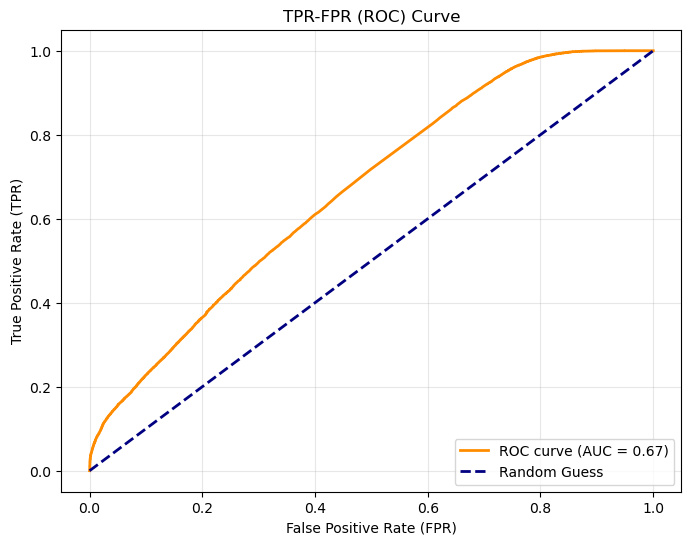

{'fpr': array([0.    , 0.    , 0.    , ..., 0.9497, 0.9497, 1.    ]),
 'tpr': array([0.00000000e+00, 3.33333333e-05, 3.00000000e-04, ...,
        9.99966667e-01, 1.00000000e+00, 1.00000000e+00]),
 'auc': 0.6681266611111111,
 'one_fpr': 0.07063333333333334,
 'one_tenth_fpr': 0.028033333333333334,
 'zero_fpr': 0.0003,
 'thresholds': array([           inf, 1.00000000e+00, 9.99866667e-01, ...,
        2.51833333e-02, 2.51666667e-02, 1.66666667e-05])}

In [274]:
# compute_attack_results
cali_rmia_res_ann = compute_attack_results(cali_rmia_score_ann, target_memberships)
visualization(cali_rmia_res_ann)
cali_rmia_res_ann


### input droupout rmia on snn

In [284]:
# choose the best dropout rate snn
for rate in [0.01, 0.02, 0.03]:
    input_dropout_fn = generate_input_dropout_fn(rate)
    cali_rmia_score_snn = cali_do_rmia_snn(target_model_snn, reference_models_snn, dataset, device, n_steps, input_dropout_fn, n_samples=1, gamma=1.0, batch_size=64)
    cali_rmia_res_snn = compute_attack_results(cali_rmia_score_snn, target_memberships)
    print(f"Dropout rate: {rate}, AUC: {cali_rmia_res_snn['auc']:.2f}")

Dropout rate: 0.01, AUC: 0.60
Dropout rate: 0.02, AUC: 0.59
Dropout rate: 0.03, AUC: 0.58


In [294]:
# cali_rmia_snn 
input_dropout_fn = generate_input_dropout_fn(0.01)
cali_rmia_score_snn = cali_rmia_snn(target_model_snn, reference_models_snn, dataset, device, n_steps, input_dropout_fn, n_samples=15, gamma=1.0, batch_size=64)

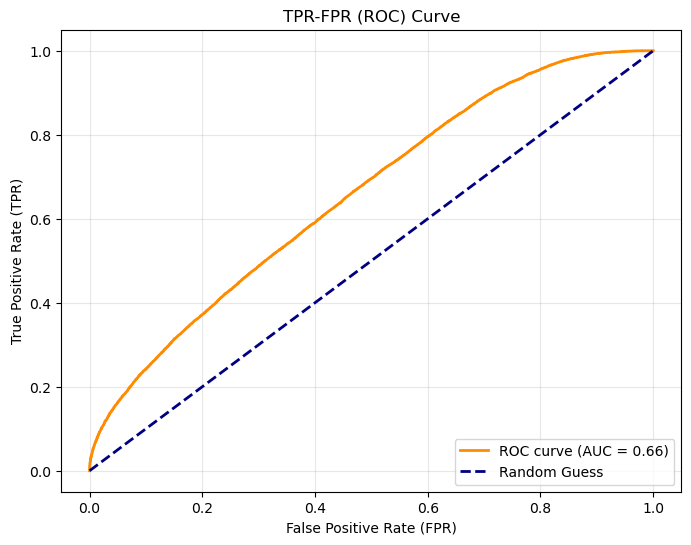

{'fpr': array([0.        , 0.        , 0.        , ..., 0.99126667, 0.99126667,
        1.        ]),
 'tpr': array([0.00000000e+00, 3.33333333e-05, 1.00000000e-04, ...,
        9.99966667e-01, 1.00000000e+00, 1.00000000e+00]),
 'auc': 0.6568336877777778,
 'one_fpr': 0.06726666666666667,
 'one_tenth_fpr': 0.020166666666666666,
 'zero_fpr': 0.0001,
 'thresholds': array([          inf, 2.0652317e+01, 1.6513479e+01, ..., 3.5166845e-02,
        3.5063505e-02, 1.0201421e-03], dtype=float32)}

In [295]:
# compute_attack_results
cali_rmia_res_snn = compute_attack_results(cali_rmia_score_snn, target_memberships)
visualization(cali_rmia_res_snn)
cali_rmia_res_snn

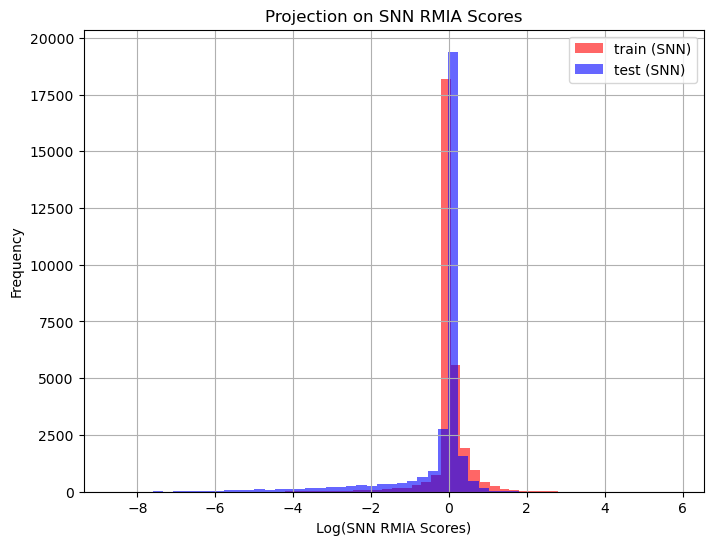

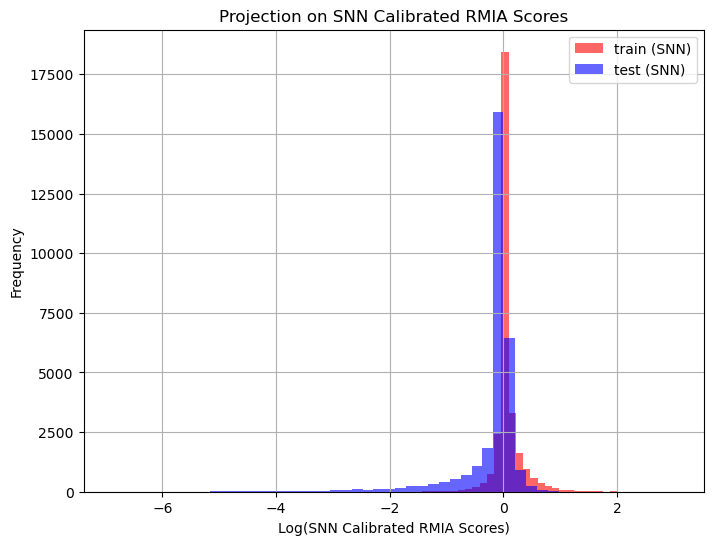

In [296]:


rmia_score_snn_train, rmia_score_snn_test = np.log(rmia_scores_snn[:30000]), np.log(rmia_scores_snn[30000:])
cali_rmia_res_snn_train, cali_rmia_res_snn_test = np.log(cali_rmia_score_snn[:30000]), np.log(cali_rmia_score_snn[30000:])
# snn
plt.figure(figsize=(8, 6))
plt.hist(rmia_score_snn_train, bins=50, color='r', alpha=0.6, label='train (SNN)')
plt.hist(rmia_score_snn_test, bins=50, color='b', alpha=0.6, label='test (SNN)')
plt.title("Projection on SNN RMIA Scores")
plt.xlabel("Log(SNN RMIA Scores)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

# cali rmia snn
plt.figure(figsize=(8, 6))
plt.hist(cali_rmia_res_snn_train, bins=50, color='r', alpha=0.6, label='train (SNN)')
plt.hist(cali_rmia_res_snn_test, bins=50, color='b', alpha=0.6, label='test (SNN)')
plt.title("Projection on SNN Calibrated RMIA Scores")
plt.xlabel("Log(SNN Calibrated RMIA Scores)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()





In [297]:
# rmia_scores_ann = rmia_ann(target_model_ann, reference_models_anns, dataset, device, n_steps, batch_size=64)
# # 57 seconds for attack_r snn 

# # auc 0.97


In [298]:
# visualization(target_model_ann,target_memberships, device,rmia_scores_ann)

In [299]:
# do_rmia_scores_snn = do_rmia_snn(target_model_snn, reference_models_snn, dataset, device, n_steps, augment_fn, n_samples=30, gamma=1.0, batch_size=64)

In [300]:
# visualization(target_model_snn, target_memberships, device, do_rmia_scores_snn)

In [154]:
# do_rmia_scores_snn = do_rmia_snn(target_model_snn, reference_models_snn, dataset, device, n_steps, augment_fn, n_samples=10, gamma=1.0, batch_size=64)

In [301]:
# visualization(target_model_snn, target_memberships, device, do_rmia_scores_snn)

In [160]:
# do_rmia_scores_snn = do_rmia_snn(target_model_snn, reference_models_snn, dataset, device, n_steps, augment_fn, n_samples=1, gamma=1.0, batch_size=64)

In [304]:
# visualization(target_model_snn, target_memberships, device, do_rmia_scores_snn)

In [63]:



# rmia_scores_snn = rmia_snn(target_model_snn, reference_models_snn, dataset, device, n_steps, batch_size=64)
# # 63 seconds for attack_r snn 

# # auc 0.61

In [305]:
# visualization(target_model_snn, target_memberships, device, rmia_scores_snn)